In this notebook, we will import some pre-trained embedding layers from [TensorFlow Hub](tfhub.dev) and we will use them in our neural network and will train the rest of the network on training sets and will evaluate the performance of the model on the test set. In the first part of the modeling, we do not finetune the embedding layer but in the second part of the modeling section, we will finetune them to improve the performance of the model.

# Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import string


import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, plot_confusion_matrix
from sklearn.preprocessing import LabelEncoder


from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from gensim.models import word2vec

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Flatten
from tensorflow.keras.layers import Dropout, Activation, Bidirectional, GlobalMaxPool1D
from tensorflow.keras.models import Sequential
from tensorflow.keras import initializers, regularizers, constraints, optimizers, layers
from tensorflow.keras.preprocessing import text, sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping

import tensorflow_hub as hub
import tensorflow_datasets as tfds


from  IPython import display

import pathlib
import shutil
import tempfile

!pip install -q git+https://github.com/tensorflow/docs

import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots
 
print("Version: ", tf.__version__)
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)


import warnings
warnings.filterwarnings('ignore')

Version:  2.8.2
Hub version:  0.12.0
GPU is available


In [2]:
!nvidia-smi

Sat Jul  2 06:27:58 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8     9W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Functions We Use

The functionsthat we use in this notebook are located in this section. The first function is the neural network that we will train on the training set. The next two functions perform some basic cleaning and the last function prints the result of the training.

In [3]:
def transfer_model(module_url, embed_size, name, trainable=False):
 
    hub_layer = hub.KerasLayer(module_url, 
                               output_shape=[embed_size],
                               input_shape=[],      ## Means that the shape of the input is arbitrary
                               dtype=tf.string, 
                               trainable = trainable)

    model = tf.keras.models.Sequential([                               
           hub_layer,
           tf.keras.layers.Dense(256, activation = "relu"), 
           tf.keras.layers.Dropout(0.3),         ### From MySelf Original Code Doesn't have this line                  
           tf.keras.layers.Dense(64, activation = "relu"),
           tf.keras.layers.Dropout(0.2),         ### From MySelf Original Code Doesn't have this line                      
           tf.keras.layers.Dense(1, activation  = "sigmoid")
                                             ])
    
    ### We use low learning rate adam optimizer because it reduces the overfitting
  
    model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate= 0.0001),
                  loss = tf.losses.BinaryCrossentropy(),
                  metrics = [tf.metrics.BinaryAccuracy(name = "accuracy")])
    
    model.summary()

    # history = 

    model.fit(X_train, y_train,
                        epochs = 100, batch_size = 32, 
                        validation_data = (X_test, y_test),
                        callbacks = [tfdocs.modeling.EpochDots(),
                                     tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 2, mode = "min"),
                                     tf.keras.callbacks.TensorBoard(logdir/name)],
                        verbose = 0)
    
    
    return model
  

In [4]:
def new_cleaning(data):
    cleaned_data = data.replace("[", "").replace("]", "").replace("'", "")\
                                    .replace(" ", "").split(",")
    return cleaned_data

In [5]:
def text_from_token(data):
    
    cleaned_sentence = " ".join(data)
    
    return  cleaned_sentence

In [6]:
def print_results(model): #, X_train, y_train, X_test, y_test):
    
    
    train_loss = model.history.history["loss"]
    train_acc  = model.history.history["accuracy"]

    test_loss = model.history.history["val_loss"]
    test_acc  = model.history.history["val_accuracy"]
    
    
    sns.set(font_scale=1)
    
    cf_matrix_test  = confusion_matrix(y_test, np.rint(model.predict(X_test)))
    cf_matrix_train = confusion_matrix(y_train, np.rint(model.predict(X_train)))
    
    
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
    ax1 = axes[0][0]
    
    g = sns.heatmap(cf_matrix_test, annot=True, cmap='Blues', ax = ax1)
    
    g.xaxis.set_ticklabels(['Fake','True'])
    g.yaxis.set_ticklabels(['Fake','True'])

    
    ax1.set_title("Confusion Matrix for Test Set")
    
    ax2 = axes[0][1]
    g = sns.heatmap(cf_matrix_train, annot=True, cmap='Blues', ax = ax2)
    g.xaxis.set_ticklabels(['Fake','True'])
    g.yaxis.set_ticklabels(['Fake','True'])

    
    ax2.set_title("Confusion Matrix for Train Set")
    
    
    
    ax3 = axes[1][0]
    
    g = sns.lineplot(x = range(1,len(train_loss)+1), 
                     y = train_loss, 
                     label = "train_loss", ax = ax3);
    g = sns.lineplot(x = range(1,len(test_loss)+1), 
                     y = test_loss, 
                     label = "test_loss", ax = ax3);


    
    ax3.set_title("Loss vs. Epochs")
    
    
    
    ax4 = axes[1][1]
    
    g = sns.lineplot(x = range(1,len(train_acc)+1), 
                     y = train_acc, 
                     label = "train_accuracy", ax = ax4);
    g = sns.lineplot(x = range(1,len(test_acc)+1), 
                     y = test_acc, 
                     label = "test_accuracy", ax = ax4);
    
    
    ax4.set_title("Accuracy vs. Epochs")
    
    
    ### Presenting Classification Report as a DataFrame
    train_class = classification_report(y_train, np.rint(model.predict(X_train)), 
                                        output_dict = True)
    test_class  = classification_report(y_test, np.rint(model.predict(X_test)), 
                                        output_dict = True)
    
    train_df = pd.DataFrame(train_class)
    test_df  = pd.DataFrame(test_class)
    
    train_df["data"] = "TRAIN"
    test_df["data"] = "TEST"
    

    report = pd.concat([test_df, train_df], axis = 0)
    report.rename(columns = {"1": f"{list(le.inverse_transform([1]))[0]}",
                             "0": f"{list(le.inverse_transform([0]))[0]}"}, inplace = True)
    report["index"] = list(report.index)

    report.set_index(["data", "index"], inplace = True)
    # report.drop("accuracy", axis = 1, inplace = True)
    
    for item in list(report.columns):
        report[item] = report[item].apply(lambda x: np.round(x,2))
    
    return report

In [7]:
model_urls = {}


model_urls[1] = {"model_name":"gnews-swivel-20dim", 
                 "embed_size": 20,
                 "url": "https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1"}

model_urls[2] = {"model_name":"nnlm-en-dim50", 
                 "embed_size": 50,
                 "url": "https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1"}

model_urls[3] = {"model_name":"nnlm-en-dim128", 
                 "embed_size": 128,
                 "url": "https://tfhub.dev/google/tf2-preview/nnlm-en-dim128/1"}

model_urls[4] = {"model_name":"Wiki-words-250", 
                 "embed_size": 250,
                 "url": "https://tfhub.dev/google/Wiki-words-250/2"}


# Importing Data

In [8]:
test = pd.read_csv("/content/drive/MyDrive/Fake-Real-News-Classification/Modeling/train_test/test.csv")
train = pd.read_csv("/content/drive/MyDrive/Fake-Real-News-Classification/Modeling/train_test/train.csv")


data  = [train, test]

for df in data:
    
    df.drop("Unnamed: 0", axis = 1, inplace = True)
    df["cleaned"] =  df["cleaned"].apply(lambda x: new_cleaning(x))
    df["cleaned_text"] =  df["cleaned"].apply(lambda x: text_from_token(x))
    df["for_glove"] =  df["for_glove"].apply(lambda x: new_cleaning(x))
    df["cleaned_glove"] =  df["for_glove"].apply(lambda x: text_from_token(x)) 

print("DONE!")

DONE!


In [9]:
le = LabelEncoder()

X_train = train["cleaned_glove"].values
y_train = le.fit_transform(train["label"])

X_test = test["cleaned_glove"].values
y_test = le.transform(test["label"])

# Modeling

In this part, we will train our neural network with different embedding layers. In the first secion of this part, we will use these embedding layers without finetuning them. After that we will finetune them to see if their performance improves or not. The embedding layers are from [TensorFlow Hub](tfhub.dev) and are as follows:

* 1st Model. In the first model we use [gnews-swivel-20dim](https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1)
* 2nd Model. In the second model we use [nnlm-en-dim50](https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1)
* 3rd Model. In the third model we use [nnlm-en-dim128](https://tfhub.dev/google/tf2-preview/nnlm-en-dim128/1) 
* 4th Model. In the forth model we use [Wiki-words-250](https://tfhub.dev/google/Wiki-words-250/2)

These are all published by Google and are token based embeddings.

## Trainable = False

In this section, we will use the embedding layers without trying to finetune them. In the next section, we will try to finetune the hyperparameters to improve the performance of the models.

In [ ]:
histories = {}

### 1st Model: `gnews-swivel-20dim`

In the first model, we use the embedding layer [gnews-swivel-20dim](https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1). This layer is a token based text embedding trained on English Google News 130GB corpus and it is published by Google. We can see that the accuracy scores for both train and test sets are equal meaning that the model is not overfitted. However, its recall and f1 scores are lower than all the models trained on 1-grams TF-IDF. So, this model would not be one of our choices at this stage. 

In [ ]:
i = 1

url = model_urls[i]["url"]
model_name = model_urls[i]["model_name"]
embed_size = model_urls[i]["embed_size"]

# histories[model_name]

model_1 = transfer_model(module_url = url, embed_size = embed_size,
                                       name = model_name, trainable = False)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 20)                400020    
                                                                 
 dense (Dense)               (None, 256)               5376      
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                16448     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 421,909
Trainable params: 21,889
Non-train

Fake      True  accuracy  macro avg  weighted avg
data  index                                                           
TEST  precision      0.86      0.84      0.85       0.85          0.85
      recall         0.74      0.92      0.85       0.83          0.85
      f1-score       0.79      0.88      0.85       0.84          0.84
      support     8719.00  13194.00      0.85   21913.00      21913.00
TRAIN precision      0.86      0.85      0.85       0.85          0.85
      recall         0.75      0.92      0.85       0.83          0.85
      f1-score       0.80      0.88      0.85       0.84          0.85
      support    17502.00  26987.00      0.85   44489.00      44489.00

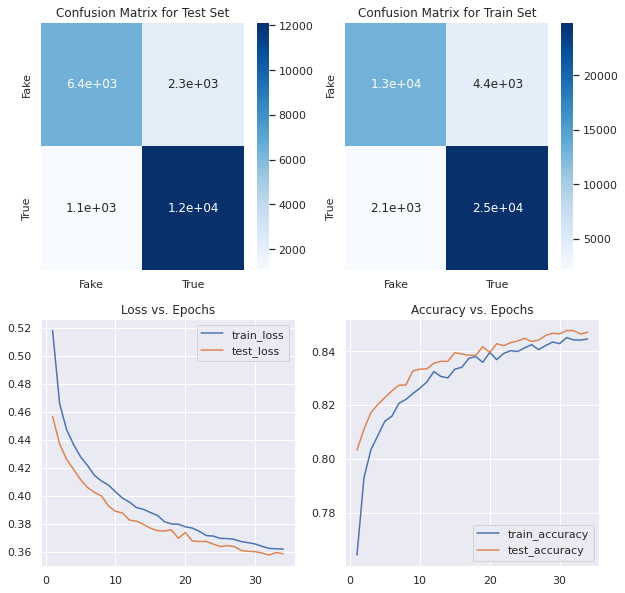

In [ ]:
print_results(model_1)

In [ ]:
import pickle
from joblib import dump, load
dump(model_1, '/content/drive/MyDrive/Fake-Real-News-Classification/pickled_nn_models/model_1.joblib') 

INFO:tensorflow:Assets written to: ram://f22efcc8-d297-4ff1-9de9-c1c362b8a1e9/assets


INFO:tensorflow:Assets written to: ram://f22efcc8-d297-4ff1-9de9-c1c362b8a1e9/assets


['/content/drive/MyDrive/Fake-Real-News-Classification/pickled_nn_models/model_1.joblib']

### 2nd Model: `nnlm-en-dim50`

In the second model we use the token based text embedding [nnlm-en-dim50] (https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1) published by Google and this embedding is trained on English Google news 7B corpus. We can see that this model is not overfitted since the accuracy scores for both training and test sets are almost equal. On the other hand the recall score for filtering out fake news is smaller than the models we trained on 1-grams TF-IDF. Therefore, we may not choose this model and will try to improve its performance by finetuning it. 


In [ ]:
i = 2

url = model_urls[i]["url"]
model_name = model_urls[i]["model_name"]
embed_size = model_urls[i]["embed_size"]

model_2 = transfer_model(module_url = url, embed_size = embed_size,
                                       name = model_name, trainable = False)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 50)                48190600  
                                                                 
 dense_3 (Dense)             (None, 256)               13056     
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 64)                16448     
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 48,220,169
Trainable params: 29,569
Non-

Fake      True  accuracy  macro avg  weighted avg
data  index                                                           
TEST  precision      0.88      0.85      0.86       0.87          0.86
      recall         0.76      0.93      0.86       0.85          0.86
      f1-score       0.81      0.89      0.86       0.85          0.86
      support     8719.00  13194.00      0.86   21913.00      21913.00
TRAIN precision      0.88      0.87      0.87       0.87          0.87
      recall         0.78      0.93      0.87       0.85          0.87
      f1-score       0.83      0.90      0.87       0.86          0.87
      support    17502.00  26987.00      0.87   44489.00      44489.00

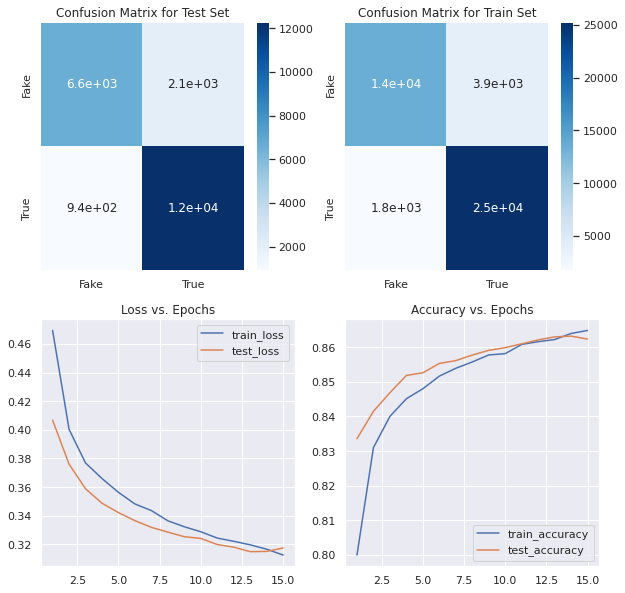

In [ ]:
print_results(model_2)

In [ ]:
import pickle
from joblib import dump, load
dump(model_2, '/content/drive/MyDrive/Fake-Real-News-Classification/pickled_nn_models/model_2.joblib') 


INFO:tensorflow:Assets written to: ram://3f4a1515-174f-48e1-91b2-5d5e72cd08a0/assets


INFO:tensorflow:Assets written to: ram://3f4a1515-174f-48e1-91b2-5d5e72cd08a0/assets


['/content/drive/MyDrive/Fake-Real-News-Classification/pickled_nn_models/model_2.joblib']

### 3rd Model

In this model, we use the token based text embedding [nnlm-en-dim128](https://tfhub.dev/google/tf2-preview/nnlm-en-dim128/1) published by Google. This layer is trained on English Google News 200B corpus. We can see that this model performs better than most of the models we trained on 1-grams TF-IDF. Therefore, this model might be a model that we consider as the final model. However, we will try to improve its performances by finetuning it in the next section.

In [ ]:
i = 3

url = model_urls[i]["url"]
model_name = model_urls[i]["model_name"]
embed_size = model_urls[i]["embed_size"]

model_3 = transfer_model(module_url = url, embed_size = embed_size,
                                       name = model_name, trainable = False)

print("DONE!")

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_2 (KerasLayer)  (None, 128)               124642688 
                                                                 
 dense_6 (Dense)             (None, 256)               33024     
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                                 
 dense_7 (Dense)             (None, 64)                16448     
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_8 (Dense)             (None, 1)                 65        
                                                                 
Total params: 124,692,225
Trainable params: 49,537
Non

Fake      True  accuracy  macro avg  weighted avg
data  index                                                           
TEST  precision      0.89      0.90      0.90       0.90          0.90
      recall         0.85      0.93      0.90       0.89          0.90
      f1-score       0.87      0.92      0.90       0.89          0.90
      support     8719.00  13194.00      0.90   21913.00      21913.00
TRAIN precision      0.92      0.92      0.92       0.92          0.92
      recall         0.87      0.95      0.92       0.91          0.92
      f1-score       0.89      0.93      0.92       0.91          0.92
      support    17502.00  26987.00      0.92   44489.00      44489.00

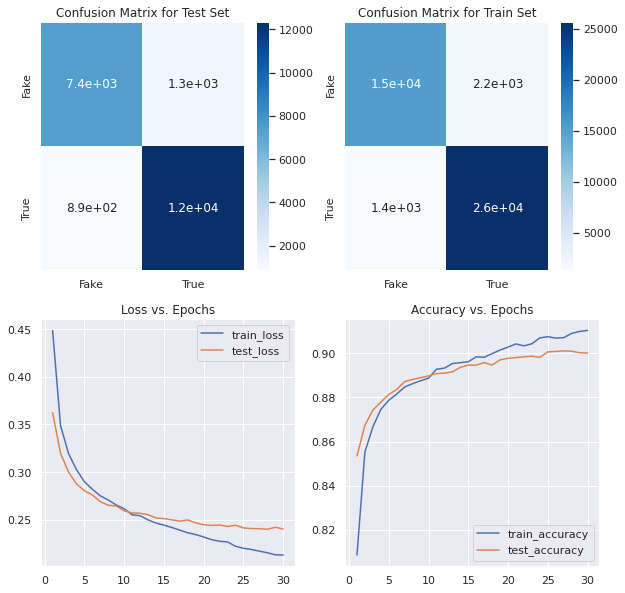

In [ ]:
print_results(model_3)

In [ ]:
# histories[model_urls[3]["model_name"]].history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
import pickle
from joblib import dump, load
dump(model_3, '/content/drive/MyDrive/Fake-Real-News-Classification/pickled_nn_models/model_3.joblib') 

INFO:tensorflow:Assets written to: ram://bf77a880-461e-4b6f-8938-fc63a2ec3efe/assets


INFO:tensorflow:Assets written to: ram://bf77a880-461e-4b6f-8938-fc63a2ec3efe/assets


['/content/drive/MyDrive/Fake-Real-News-Classification/pickled_nn_models/model_3.joblib']

### 4th Model

In the last model of this section, we will use the token based text embedding [Wiki-words-250](https://tfhub.dev/google/Wiki-words-250/2) published by Google. This model is trained on English Wikipedia corpus. We can see that the model's recall score for filtering out fake news in the test set is smaller than those we found by models trained on 1-grams TF-IDF. Therefore, we will try to improve its performance by finetuning it.

In [ ]:
i = 4

url = model_urls[i]["url"]
model_name = model_urls[i]["model_name"]
embed_size = model_urls[i]["embed_size"]

model_4 = transfer_model(module_url = url, embed_size = embed_size, 
                                       name = model_name, trainable = False)

print("DONE!")

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_15 (KerasLayer)  (None, 250)              252343750 
                                                                 
 dense_45 (Dense)            (None, 256)               64256     
                                                                 
 dropout_30 (Dropout)        (None, 256)               0         
                                                                 
 dense_46 (Dense)            (None, 64)                16448     
                                                                 
 dropout_31 (Dropout)        (None, 64)                0         
                                                                 
 dense_47 (Dense)            (None, 1)                 65        
                                                                 
Total params: 252,424,519
Trainable params: 80,769
No

Fake      True  accuracy  macro avg  weighted avg
data  index                                                           
TEST  precision      0.90      0.86      0.87       0.88          0.87
      recall         0.76      0.94      0.87       0.85          0.87
      f1-score       0.82      0.90      0.87       0.86          0.87
      support     8719.00  13194.00      0.87   21913.00      21913.00
TRAIN precision      0.91      0.86      0.88       0.89          0.88
      recall         0.77      0.95      0.88       0.86          0.88
      f1-score       0.83      0.90      0.88       0.87          0.88
      support    17502.00  26987.00      0.88   44489.00      44489.00

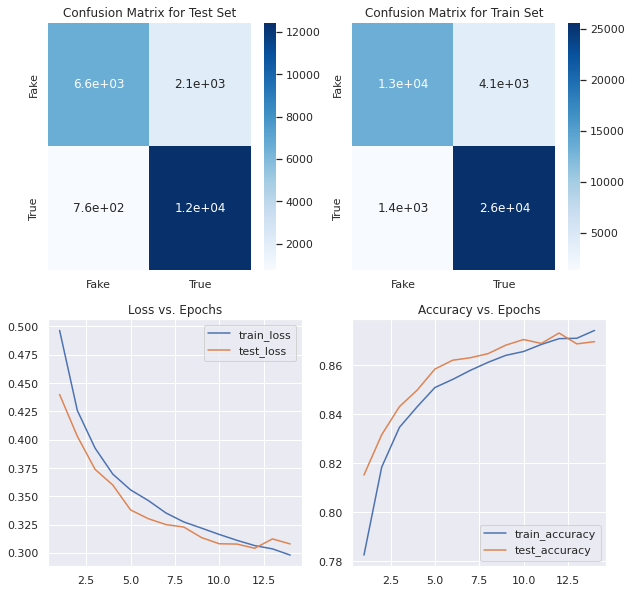

In [ ]:
print_results(model_4)

In [ ]:
import pickle
from joblib import dump, load
dump(model_4, '/content/drive/MyDrive/Fake-Real-News-Classification/pickled_nn_models/model_4.joblib') 


INFO:tensorflow:Assets written to: ram://0cfb561a-4f71-4305-bf68-76cb8585fb91/assets


INFO:tensorflow:Assets written to: ram://0cfb561a-4f71-4305-bf68-76cb8585fb91/assets


['/content/drive/MyDrive/Fake-Real-News-Classification/pickled_nn_models/model_4.joblib']

## Trainable = True

In this section, we will try to finetune the embedding layer by training the model on training set.

### 1st model trained

In this section, we will finetune the embedding layer of the 1st model by training it on the training set. We can see that the finetuning improved the model's performance. Also, we can see that the this model performs better than all the other models trained on 1-grams TF-IDF. Therefore, we would suggest this model.

In [ ]:
i = 1

url = model_urls[i]["url"]
model_name = model_urls[i]["model_name"]
embed_size = model_urls[i]["embed_size"]

model_trained_1 = transfer_model(module_url = url, embed_size = embed_size,
                                       name = model_name, trainable = True)

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_16 (KerasLayer)  (None, 20)               400020    
                                                                 
 dense_48 (Dense)            (None, 256)               5376      
                                                                 
 dropout_32 (Dropout)        (None, 256)               0         
                                                                 
 dense_49 (Dense)            (None, 64)                16448     
                                                                 
 dropout_33 (Dropout)        (None, 64)                0         
                                                                 
 dense_50 (Dense)            (None, 1)                 65        
                                                                 
Total params: 421,909
Trainable params: 421,909
Non-t

Fake      True  accuracy  macro avg  weighted avg
data  index                                                           
TEST  precision      0.90      0.91      0.91       0.91          0.91
      recall         0.87      0.94      0.91       0.90          0.91
      f1-score       0.88      0.93      0.91       0.91          0.91
      support     8719.00  13194.00      0.91   21913.00      21913.00
TRAIN precision      0.94      0.94      0.94       0.94          0.94
      recall         0.91      0.96      0.94       0.94          0.94
      f1-score       0.93      0.95      0.94       0.94          0.94
      support    17502.00  26987.00      0.94   44489.00      44489.00

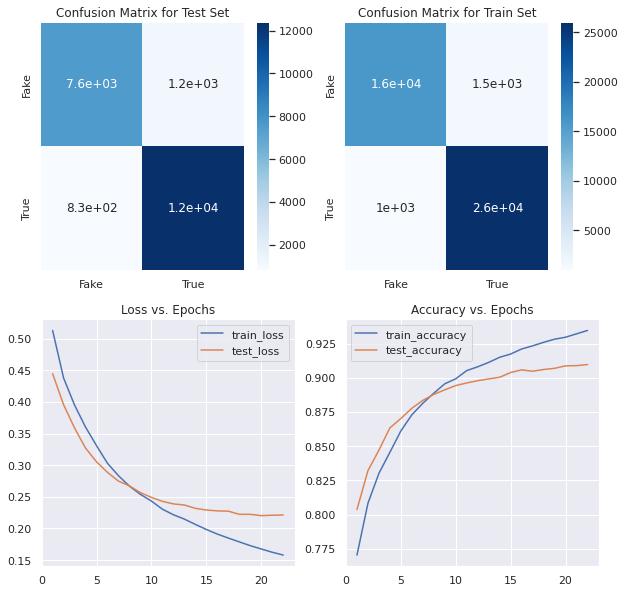

In [ ]:
print_results(model_trained_1)

In [ ]:
import pickle
from joblib import dump, load

dump(model_trained_1, '/content/drive/MyDrive/Fake-Real-News-Classification/pickled_nn_models/model_trained_1.joblib') 

INFO:tensorflow:Assets written to: ram://f3e1714c-b278-4140-964d-9e2d4dc73f2c/assets


INFO:tensorflow:Assets written to: ram://f3e1714c-b278-4140-964d-9e2d4dc73f2c/assets


['/content/drive/MyDrive/Fake-Real-News-Classification/pickled_nn_models/model_trained_1.joblib']

### 2nd model trained

Now we try to finetune the embedding layers of the 2nd model on training sets to improve its performance. By comparing the results of this model compared to the case where it was not finetuned, we can see that the this model has a higher recall and F1 scores when it is predicting the test sets. Therefore, the finetunning improved the performance of this model even though due to early stoping the loss function did not converge. Moreover, this model outperform all the other models trained on 1-grams TF-IDF. 

In [ ]:
i = 2

url = model_urls[i]["url"]
model_name = model_urls[i]["model_name"]
embed_size = model_urls[i]["embed_size"]

model_trained_2 = transfer_model(module_url = url, embed_size = embed_size,
                                       name = model_name, trainable = True)

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_17 (KerasLayer)  (None, 50)               48190600  
                                                                 
 dense_51 (Dense)            (None, 256)               13056     
                                                                 
 dropout_34 (Dropout)        (None, 256)               0         
                                                                 
 dense_52 (Dense)            (None, 64)                16448     
                                                                 
 dropout_35 (Dropout)        (None, 64)                0         
                                                                 
 dense_53 (Dense)            (None, 1)                 65        
                                                                 
Total params: 48,220,169
Trainable params: 48,220,169

Fake      True  accuracy  macro avg  weighted avg
data  index                                                           
TEST  precision      0.90      0.93      0.92       0.91          0.92
      recall         0.89      0.94      0.92       0.91          0.92
      f1-score       0.89      0.93      0.92       0.91          0.92
      support     8719.00  13194.00      0.92   21913.00      21913.00
TRAIN precision      0.97      0.97      0.97       0.97          0.97
      recall         0.96      0.98      0.97       0.97          0.97
      f1-score       0.96      0.98      0.97       0.97          0.97
      support    17502.00  26987.00      0.97   44489.00      44489.00

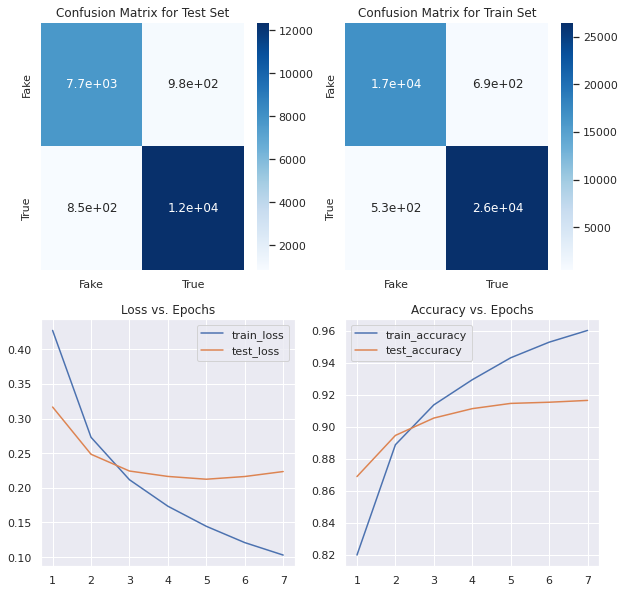

In [ ]:
print_results(model_trained_2)

In [ ]:
import pickle
from joblib import dump, load
dump(model_trained_2, '/content/drive/MyDrive/Fake-Real-News-Classification/pickled_nn_models/model_trained_2.joblib') 


INFO:tensorflow:Assets written to: ram://8ae23858-0c16-4eb6-842d-e537c5382096/assets


INFO:tensorflow:Assets written to: ram://8ae23858-0c16-4eb6-842d-e537c5382096/assets


['/content/drive/MyDrive/Fake-Real-News-Classification/pickled_nn_models/model_trained_2.joblib']

### 3rd model trained

Now we try to finetune the embedding layers of the 3rd model on training sets to improve its performance. By comparing the results of this model compared to the case where it was not finetuned, we can see that the this model has a higher recall and F1 scores when it is predicting the test sets. Therefore, the finetunning improved the performance of this model, even thoug the loss function did not converge because of early stopping. Moreover, this model out performs all the other models introduced in this project. Therefore, this model will be the final model we introduced in this project.

In [ ]:
i = 3

url = model_urls[i]["url"]
model_name = model_urls[i]["model_name"]
embed_size = model_urls[i]["embed_size"]

model_trained_3 = transfer_model(module_url = url, embed_size = embed_size,
                                       name = model_name, trainable = True)

print("DONE!")

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_18 (KerasLayer)  (None, 128)              124642688 
                                                                 
 dense_54 (Dense)            (None, 256)               33024     
                                                                 
 dropout_36 (Dropout)        (None, 256)               0         
                                                                 
 dense_55 (Dense)            (None, 64)                16448     
                                                                 
 dropout_37 (Dropout)        (None, 64)                0         
                                                                 
 dense_56 (Dense)            (None, 1)                 65        
                                                                 
Total params: 124,692,225
Trainable params: 124,692,2

Fake      True  accuracy  macro avg  weighted avg
data  index                                                           
TEST  precision      0.90      0.93      0.92       0.91          0.92
      recall         0.89      0.93      0.92       0.91          0.92
      f1-score       0.90      0.93      0.92       0.91          0.92
      support     8719.00  13194.00      0.92   21913.00      21913.00
TRAIN precision      0.98      0.98      0.98       0.98          0.98
      recall         0.98      0.98      0.98       0.98          0.98
      f1-score       0.98      0.98      0.98       0.98          0.98
      support    17502.00  26987.00      0.98   44489.00      44489.00

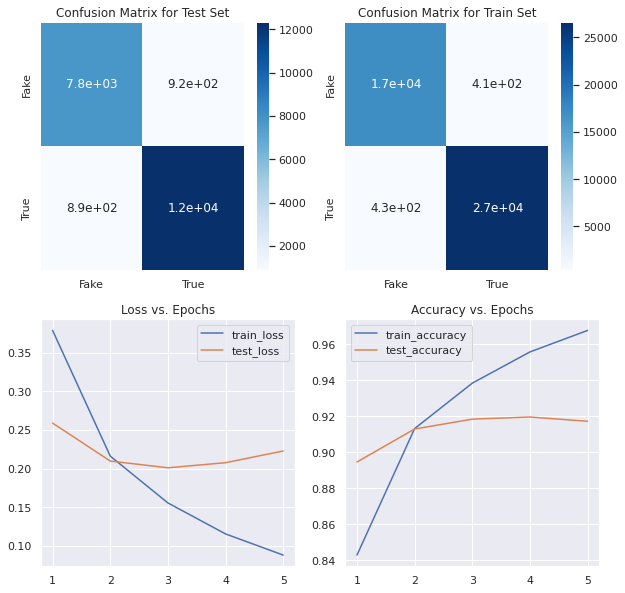

In [ ]:
print_results(model_trained_3)

In [ ]:
import pickle
from joblib import dump, load
dump(model_trained_3, '/content/drive/MyDrive/Fake-Real-News-Classification/pickled_nn_models/model_trained_3.joblib') 


INFO:tensorflow:Assets written to: ram://f0692f6f-e093-4fab-9469-b9c486940eee/assets


INFO:tensorflow:Assets written to: ram://f0692f6f-e093-4fab-9469-b9c486940eee/assets


['/content/drive/MyDrive/Fake-Real-News-Classification/pickled_nn_models/model_trained_3.joblib']

### 4th model trained

In this section, we will finetune the embedding layer of the 4th model by using the training set. We can see that the finetuning improved the model's performance. However, this model does not have the highest recall and f1 scores when filtering out fake news in the test sets. Therefore, this model is not out final model.

In [10]:
i = 4

url = model_urls[i]["url"]
model_name = model_urls[i]["model_name"]
embed_size = model_urls[i]["embed_size"]

model_trained_4 = transfer_model(module_url = url, embed_size = embed_size, 
                                       name = model_name, trainable = True)

print("DONE!")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 250)               252343750 
                                                                 
 dense (Dense)               (None, 256)               64256     
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                16448     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 252,424,519
Trainable params: 252,424,519


Fake      True  accuracy  macro avg  weighted avg
data  index                                                           
TEST  precision      0.92      0.91      0.91       0.91          0.91
      recall         0.85      0.95      0.91       0.90          0.91
      f1-score       0.88      0.93      0.91       0.91          0.91
      support     8719.00  13194.00      0.91   21913.00      21913.00
TRAIN precision      0.98      0.98      0.98       0.98          0.98
      recall         0.97      0.99      0.98       0.98          0.98
      f1-score       0.98      0.99      0.98       0.98          0.98
      support    17502.00  26987.00      0.98   44489.00      44489.00

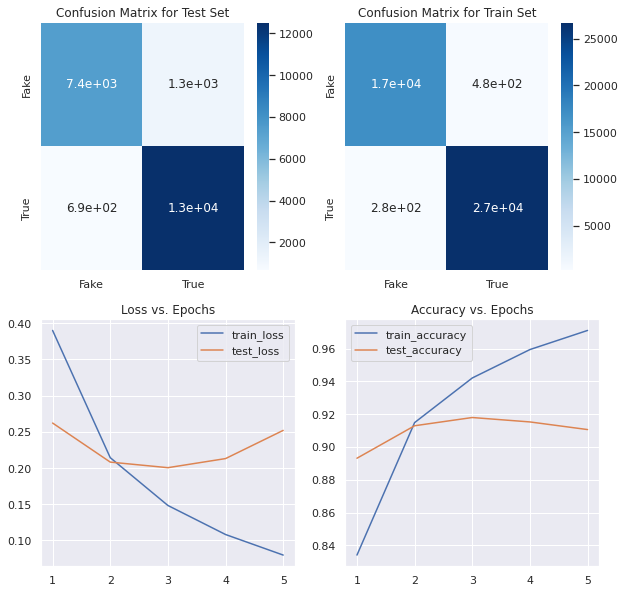

In [11]:
print_results(model_trained_4)

In [ ]:
import pickle
from joblib import dump, load
dump(model_trained_4, '/content/drive/MyDrive/Fake-Real-News-Classification/pickled_nn_models/model_trained_4.joblib') 


# Summary of Models and Conclusion

In this notebook, we used different embedding layers published by Google that we found on [TensorFlow Hub](tfhub.dev). We first used these embeddings without finetuning them and then we finetuned them to improve their performances. We noticed that finetuning improved the performance of the model. We mighe be able to enhance th models' performance by optimizing the dense layers and using other type of layers such as LSTM or Conv1D or using [optuna](https://optuna.org/). At the end of this notebook, we will introduce the 3rd model with finetuned embedding as our suggested model to to use to detect fake news.
